# Looking at coherence 


In [1]:
# import libraries
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import math
from rasterio.enums import Resampling

from pathlib import Path
from datetime import datetime
from time import time
import tifffile as tif

import matplotlib.pyplot as plt

# uavsar code
from uavsar_pytools.convert.tiff_conversion import read_annotation
from uavsar_pytools.incidence_angle import calc_inc_angle

/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os

scripts_dir = (os.path.dirname(os.getcwd()) + '/scripts/')
sys.path.append(scripts_dir)

from plotting import plot_tifs_grid, plot_coherence_matrix
from coherence import calc_coherence_unweighted, calc_coherence_matrix

In [5]:
# load geocoded SLC data
data_dir = '../data/snowex_lowman/slcs_geocoded/'
raw_dir = '../data/snowex_lowman/slcs_raw/'
in_dir = Path(data_dir)
slcs = sorted(list(in_dir.glob('*05208_21*geoslc.tif'))) 
anns = sorted(list(Path(raw_dir).glob('*05208_21*ann')))        # use just 05208 flight 2021 data for now

# create a list of geospatial xarrays 
stack = []
dates = []
for i, (slc, ann) in enumerate(zip(slcs, anns, strict = True)):
    d = read_annotation(ann)
    d = pd.DataFrame(d).T
    timestamp = d.loc['start time of acquisition', 'value']
    dates.append(timestamp)

    print(str(slc))
    xarr = rxa.open_rasterio(str(slc))  # shape: (2, rows, cols)
    # print(xarr)
    real = xarr.sel(band=1)
    imag = xarr.sel(band=2)
    complex_data = real.values + 1j * imag.values # Combine bands into complex array

    # create a new data array with complex numbers 
    complex_xarr = real.copy(data=complex_data)
    stack.append(complex_xarr)


../data/snowex_lowman/slcs_geocoded/lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8_geoslc.tif


<xarray.DataArray (y: 1435, x: 1864)> Size: 11MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(1435, 1864), dtype=float32)
Coordinates:
  * x            (x) float64 15kB -115.7 -115.7 -115.7 ... -115.6 -115.6 -115.6
  * y            (y) float64 11kB 43.98 43.98 43.98 43.98 ... 43.91 43.91 43.91
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        2478.0634765625
    STATISTICS_MEAN:           2086.3836623687
    STATISTICS_MINIMUM:        1578.3062744141
    STATISTICS_STDDEV:         207.21079218365
    STATISTICS_VALID_PERCENT:  52.09
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:           

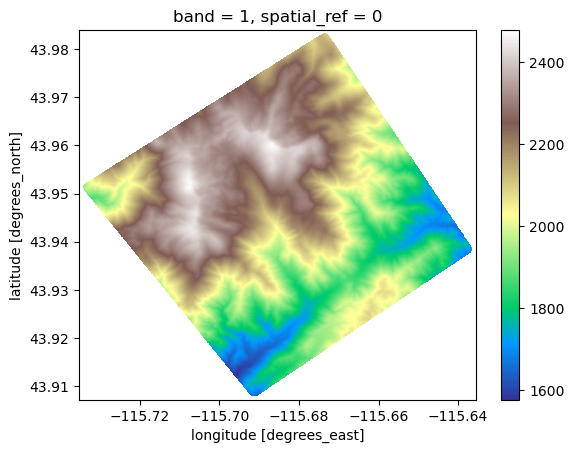

In [11]:
# load dem
res = 5  # desired resolution in meters
dem_dir = '../data/snowex_lowman/snex_qsi_lidar/'
dem = rxa.open_rasterio(dem_dir + 'SNEX20_QSI_DEM_0.5M_USIDMC_20210917_20210917.tif')
resampled_dem = dem.rio.reproject(
        dem.rio.crs, # Reproject to the same CRS
        resampling=Resampling.average, # Use average for DEM aggregation
        resolution=(res, res)
    )
reprojected_dem = resampled_dem.rio.reproject(
        stack[0].rio.crs, # Reproject to the CRS of the radar data
    )
reprojected_dem = reprojected_dem.squeeze()  # remove band dimension
reprojected_dem = reprojected_dem.where(reprojected_dem != dem.rio.nodata)  # set nodata values to NaN

print(reprojected_dem)
reprojected_dem.plot(cmap = 'terrain')

In [6]:
lkv_fp = data_dir + 'lowman_05208_01_BU_s2_2x8_geolkv.tif'
lkv = rxa.open_rasterio(lkv_fp)

print(type(lkv))
print(lkv.shape)
print(dates)

<class 'xarray.core.dataarray.DataArray'>
(3, 8333, 4896)
[Timestamp('2021-02-03 13:16:28-0700', tz='US/Mountain'), Timestamp('2021-02-10 16:06:16-0700', tz='US/Mountain'), Timestamp('2021-03-03 11:28:34-0700', tz='US/Mountain'), Timestamp('2021-03-10 11:03:07-0700', tz='US/Mountain'), Timestamp('2021-03-16 12:09:25-0600', tz='US/Mountain'), Timestamp('2021-03-22 10:58:31-0600', tz='US/Mountain')]


In [7]:
# # calculate coherence for all image pairs in stack
# coherences = []
# for i in range(len(stack)) : 
#     for j in range(len(stack)) : 
#         # if (j > 2) : 
#         #     break
#         if (i >= j) : 
#             continue
#         start_time = time()
#         print(f"Calculating coherence for img {i} and img {j}")
#         # print(type(stack[i]))
#         # print(type(stack[j]))
#         coh = (calc_coherence_unweighted(stack[i], stack[j]))
#         end_time = time()
#         elapsed_time = end_time - start_time
#         print(f"   elapsed time: {elapsed_time} seconds")

#         coherences.append(coh)

# tif.imwrite(data_dir + 'lowman_05208_coherences.stack', coherences, bigtiff=True)
coherences_3d = tif.imread(data_dir + 'lowman_05208_coherences.stack')
coherences = [coherences_3d[i] for i in range(coherences_3d.shape[0])]


In [6]:
print(stack[0].rio.bounds)

<bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x115d2e5d0>>


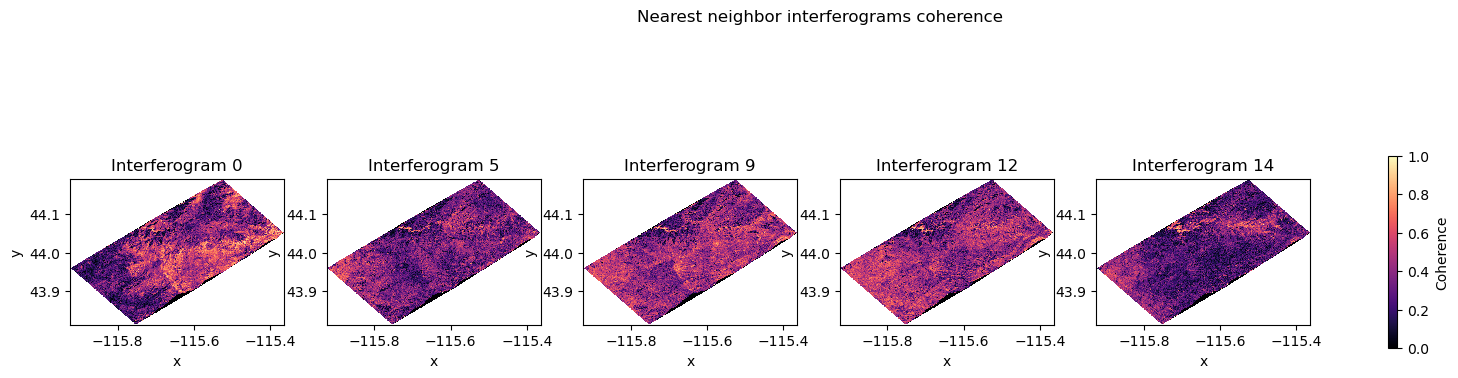

In [8]:
# downsample nearest neighbors to be able to plot them side-by-side 
indices = [0, 5, 9, 12, 14]
# indices = range(len(coherences))  

fig, axes = plt.subplots(int(np.ceil(len(indices) / len(stack))), int(min(len(stack), len(indices))), figsize=(20, 5))
axes = axes.flatten()

for idx in indices :
    # print(idx)
    coh = stack[0].copy(data = coherences[idx])

    # downsample by factor of 10 for plotting
    coh_ds = coh.isel(x=slice(None, None, 10), y=slice(None, None, 10))
    ax = axes[indices.index(idx)]
    im = coh_ds.plot(ax=ax, cmap='magma', vmin=0, vmax=1, robust=True, add_colorbar=False)
    ax.set_title(f'Interferogram {idx}')
    ax.set_aspect('equal')  # Ensures equal degree dimensions

for j in range(len(indices), len(axes)):
    axes[j].axis('off')

fig.suptitle('Nearest neighbor interferograms coherence')
fig.colorbar(im, ax=axes, shrink=0.5, label='Coherence')
# plt.tight_layout()
plt.show()

In [ ]:
# def calc_coherence_matrix(coherences, num_scenes, method='mean', threshold=0.3):

#     # Accept list or 3D numpy array
#     if isinstance(coherences, list):
#         arrs = coherences
#     elif isinstance(coherences, np.ndarray) and coherences.ndim == 3:
#         arrs = [coherences[i] for i in range(coherences.shape[0])]
#     else:
#         raise ValueError("coherences must be a list or 3D numpy array")

#     if math.comb(num_scenes, 2) != len(arrs):
#         raise ValueError("Number of coherence arrays does not match number of scenes")

#     mtx = np.zeros([num_scenes, num_scenes])
#     counter = 0
#     for i in range(num_scenes):
#         for j in range(i, num_scenes):
#             if i == j:
#                 mtx[i, j] = 1
#                 continue
#             arr_vals = arrs[counter]
#             if method == 'mean':
#                 mtx[i, j] = np.nanmean(arr_vals)
#             elif method == 'prop':
#                 mtx[i, j] = np.sum(arr_vals > threshold) / arr_vals.size
#             counter += 1

#     mtx = np.where(mtx == 0, np.nan, mtx)
#     return mtx

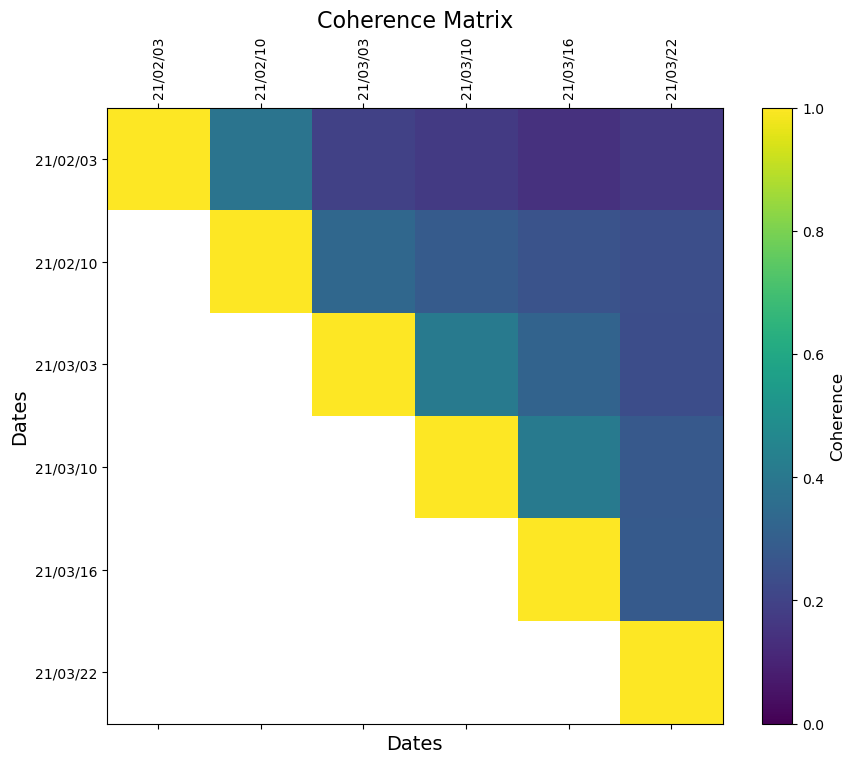

In [9]:
coherence_matrix = calc_coherence_matrix(coherences_3d, len(stack))
plot_coherence_matrix(coherence_matrix, dates = dates)

In [12]:
# clip data to the size of the dem 
# coh_spatial = stack[0].copy(data = coherences[0])
# clipped = coh_spatial.rio.reproject_match(reprojected_dem, 
#                                           nodata = np.nan,
#                                           resampling = Resampling.average)
# clipped = clipped.where(~np.isnan(reprojected_dem))

clipped_coherences = []
for i in range(len(coherences)) :
    coh_spatial = stack[0].copy(data = coherences[i])
    clipped = coh_spatial.rio.reproject_match(reprojected_dem, 
                                            nodata = np.nan,
                                            resampling = Resampling.average)
    clipped = clipped.where(~np.isnan(reprojected_dem))
    # print(type(clipped))
    # print(clipped)
    clipped_coherences.append(clipped)

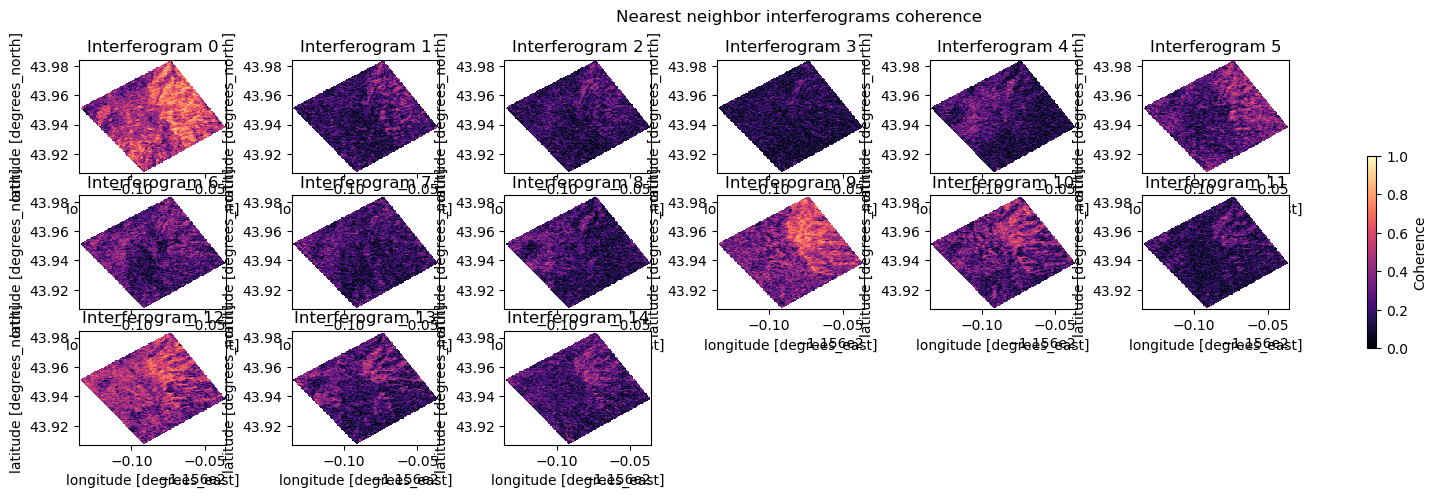

In [13]:
# downsample nearest neighbors to be able to plot them side-by-side 
indices = [0, 5, 9, 12, 14]
indices = range(len(coherences))  

fig, axes = plt.subplots(int(np.ceil(len(indices) / len(stack))), int(min(len(stack), len(indices))), figsize=(20, 5))
axes = axes.flatten()

for idx in indices :
    # print(idx)
    coh = clipped_coherences[0].copy(data = clipped_coherences[idx])

    # downsample by factor of 10 for plotting
    coh_ds = coh.isel(x=slice(None, None, 10), y=slice(None, None, 10))
    ax = axes[indices.index(idx)]
    im = coh_ds.plot(ax=ax, cmap='magma', vmin=0, vmax=1, robust=True, add_colorbar=False)
    ax.set_title(f'Interferogram {idx}')
    ax.set_aspect('equal')  # Ensures equal degree dimensions

for j in range(len(indices), len(axes)):
    axes[j].axis('off')

fig.suptitle('Nearest neighbor interferograms coherence')
fig.colorbar(im, ax=axes, shrink=0.5, label='Coherence')
# plt.tight_layout()
plt.show()

In [14]:
lkv_spatial = stack[0].copy(data = lkv)
clipped = lkv_spatial.rio.reproject_match(reprojected_dem, 
                                          nodata = np.nan,
                                          resampling = Resampling.average)
clipped = clipped.where(~np.isnan(reprojected_dem))

# calc_inc_angle(resampled_dem,)

ValueError: Data shape (3, 8333, 4896) must match shape of object (8333, 4896)

/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


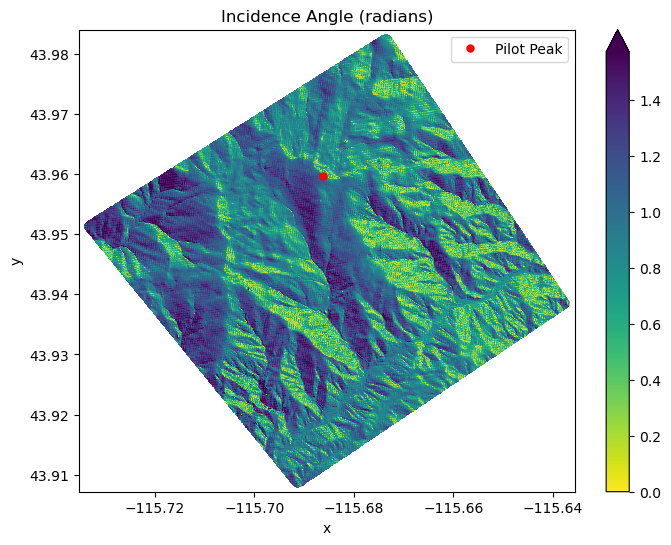

In [15]:
inc_fp = data_dir + 'lowman_05208_inc.tif'
inc_angle = rxa.open_rasterio(inc_fp)

inc_rad = np.deg2rad(inc_angle)

# inc_angle.plot()

fig, ax = plt.subplots(figsize=(8, 6))
im = inc_rad.plot(ax=ax, cmap='viridis_r', vmin = 0, vmax = ((1/2) * np.pi), robust=True, add_colorbar=True)

# Add a point at (lon_pt, lat_pt)
lon_pt = -115.686113
lat_pt = 43.959596
ax.plot(lon_pt, lat_pt, marker='o', color='red', markersize=5, linestyle='None', label='Pilot Peak')

ax.legend()
ax.set_title('Incidence Angle (radians)')
plt.show()

/var/folders/fj/nxxmv5353nj2t68jvxn1wc4w0000gp/T/ipykernel_24907/3870590181.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


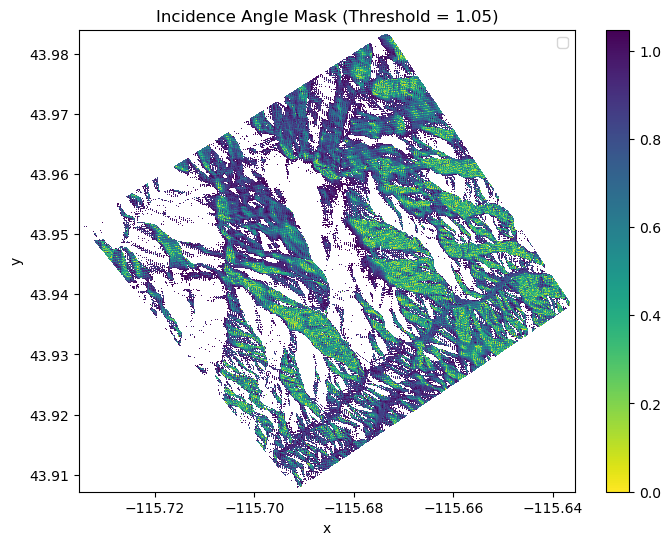

In [16]:
# create an incidence angle mask 
threshold = (1/3) * np.pi

inc_mask = inc_rad.copy(data = inc_rad.where(inc_rad < threshold))

fig, ax = plt.subplots(figsize=(8, 6))
im = inc_mask.plot(ax=ax, cmap='viridis_r', vmin = 0, vmax = threshold, robust=True, add_colorbar=True)
ax.legend()
ax.set_title(f'Incidence Angle Mask (Threshold = {threshold:.2f})')
plt.show()

<class 'xarray.core.dataarray.DataArray'>


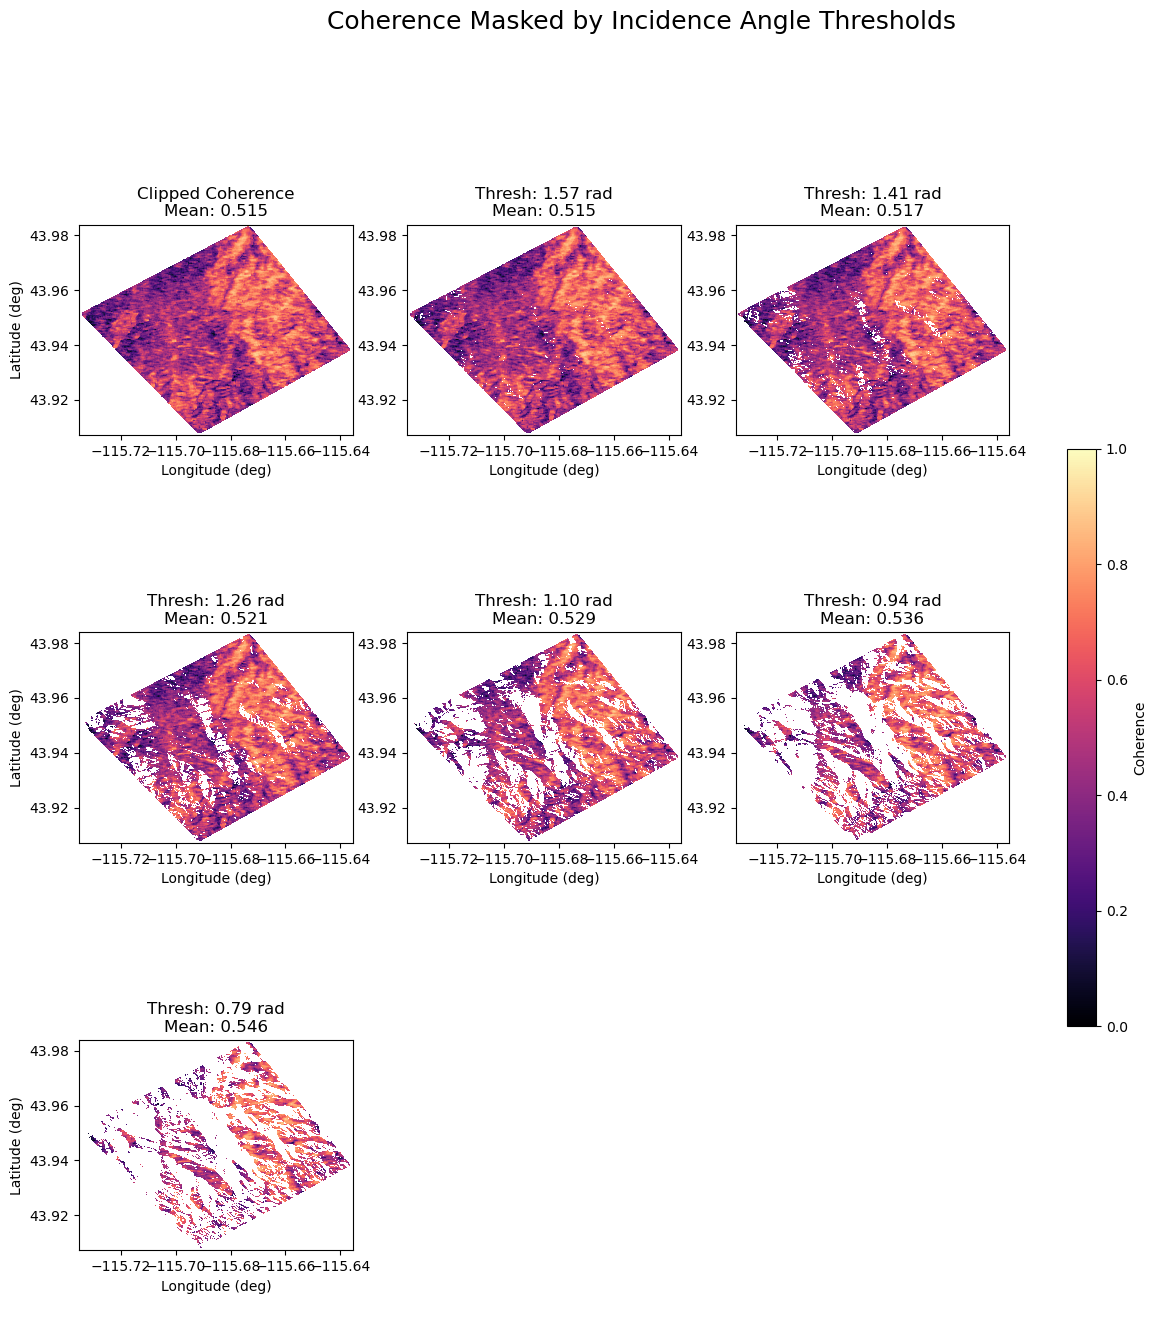

In [17]:
c = clipped_coherences[0]
print(type(c))

num_thresholds = 6
thresholds = np.linspace((1/2) * np.pi, (1/4) * np.pi, num_thresholds)  # example range

ncols = 3
nrows = int(np.ceil((num_thresholds+1) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

axes = axes.flatten()
avg_coh = np.nanmean(c.values)
im0 = c.plot(ax=axes[0], cmap='magma', vmin=0, vmax=1, robust=True, add_colorbar=False)
axes[0].set_title(f'Clipped Coherence\nMean: {avg_coh:.3f}')
axes[0].set_aspect('equal')
axes[0].set_xlabel('Longitude (deg)')
axes[0].set_ylabel('Latitude (deg)')

for i, threshold in enumerate(thresholds):
    # Mask coherence where incidence angle >= threshold
    mask = inc_rad.where(inc_rad < threshold)
    masked_coh = c.where(~np.isnan(mask))
    avg_masked_coh = np.nanmean(masked_coh.values)

    ax = axes.flat[i+1]
    im = masked_coh.plot(ax=ax, cmap='magma', vmin=0, vmax=1, robust=True, add_colorbar=False)
    ax.set_title(f'Thresh: {threshold:.2f} rad\nMean: {avg_masked_coh:.3f}')
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude (deg)')
    if ((i+1) % ncols) == 0:
        ax.set_ylabel('Latitude (deg)')
    else : 
        ax.set_ylabel("")


# Hide unused axes
for j in range(i+2, nrows*ncols):
    axes.flat[j].axis('off')

fig.suptitle('Coherence Masked by Incidence Angle Thresholds', fontsize=18)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Coherence')
# plt.tight_layout()
plt.show()